## Image Segementation

### Import all necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

plt.rcParams['figure.figsize'] = [15, 15]

### Create a class for the DeepLabV3+ neural network with functions for feature extraction,

In [2]:
class DeepLab:
    
    def __init__(self, selected_layer=405):
        from model import Deeplabv3
        import tensorflow as tf
        
        self.model = Deeplabv3(weights="pascal_voc", input_shape=(512, 512, 3), backbone="xception", classes=21)
        self.model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        outputs = [layer.output for layer in self.model.layers]
        self.model = tf.keras.models.Model(inputs=self.model.inputs, outputs=outputs)
        
        for layer in self.model.layers: layer.trainable = False
        self.image_list = []
        self.selected_layer = selected_layer
        
    def summary(self):
        self.model.summary()

    def preprocess_image(self, image):
        image = resize(image, (512, 512), anti_aliasing=True)
        image = np.expand_dims(image, axis=0)
        return image
    
    def activations(self):
        activation_layers = []
        for i in range(len(self.model.layers)):
            layer = self.model.layers[i]
            if layer.name.split('_')[0] == 'activation':
                activation_layers.append(i)
        return activation_layers
    
    def list_images(self, path):
        import glob
        for filename in glob.glob(path + '/*.jpg'):
            img = plt.imread(filename)
            img = self.preprocess_image(img)
            self.image_list.append(img)
    
    def get_features(self):
        feature_list = []
        for img in self.image_list:
            feature_map = self.model.predict(img)[self.selected_layer]
            feature_list.append(feature_map)
        return np.array(feature_list).squeeze(axis=1)
    
    def predict(self, image):
        image = self.preprocess_image(image)
        return self.model.predict(image)[self.selected_layer]

### Creat an instance of the neural network class and extract the features from the last activation layer for a list of 8 images.

In [3]:
deeplab = DeepLab()
deeplab.list_images('C:\\Users\\me\\Desktop\\data\\examples')
feature_map = deeplab.get_features()

In [4]:
import glob
filenames = glob.glob('C:\\Users\\me\\Desktop\\data\\examples\\*.jpg')

### The feature map is a numpy array of high dimention.

In [5]:
print(feature_map.shape)
n, w, h, d = feature_map.shape

(8, 128, 128, 256)


### To avoid the effect of the curse of dimentionality, reduce the features using Principal Component Analysis. Select the 8 most significant components.

In [6]:
pca = PCA(n_components=8)
r = pca.fit_transform(feature_map.reshape(-1, d))

### Plot the reduced features for each image.

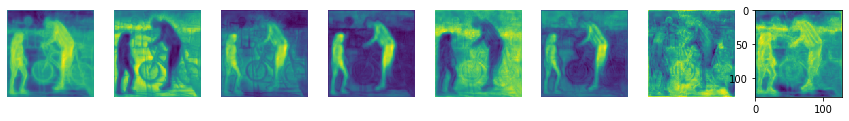

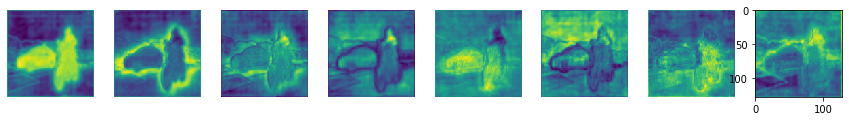

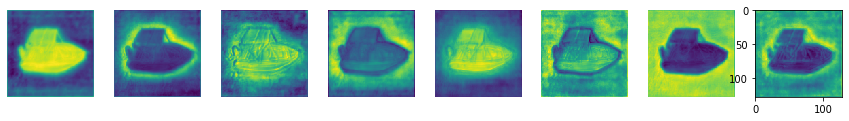

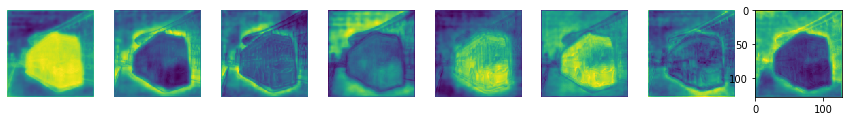

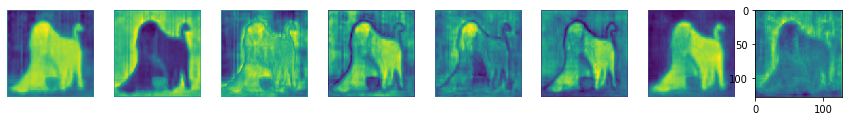

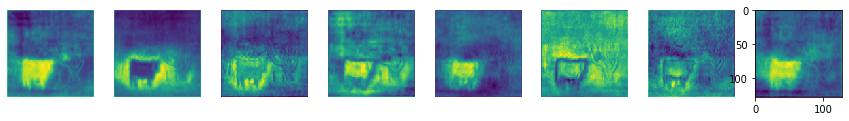

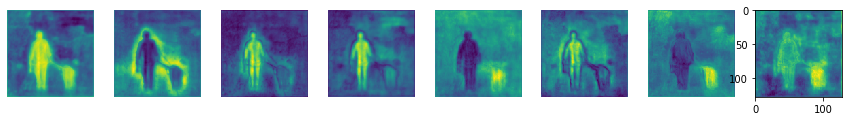

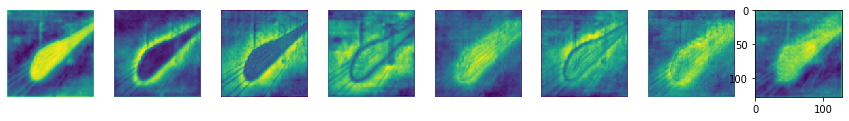

In [7]:
all_data = r.reshape(n, w, h, 8)

for i in range(n):
    for j in range(8):
        plt.axis('off')
        plt.subplot(8, 8, j+1)
        plt.imshow(all_data[i,:,:,j])
    plt.show()

### To do image segmentation we will use a Gaussian Mixture Model. Create a function to plot the original image and the segmented image side by side.

In [8]:
def plot_results(gmm):
    for i in range(n):
        prediction = gmm.predict(all_data[i].reshape(-1, 8)).reshape(w, h)
        original_image = plt.imread(filenames[i])

        plt.subplot(1, 2, 1)
        plt.title('Original Image', fontsize = 16)
        plt.imshow(original_image)

        plt.subplot(1, 2, 2)
        plt.title('Segmented Image', fontsize = 16)
        plt.imshow(prediction, cmap='PuBu')
        plt.show()

### Create a Gaussian Mixture Model for n = 2 components. Fit it with the reduced features and plot the result for each image.

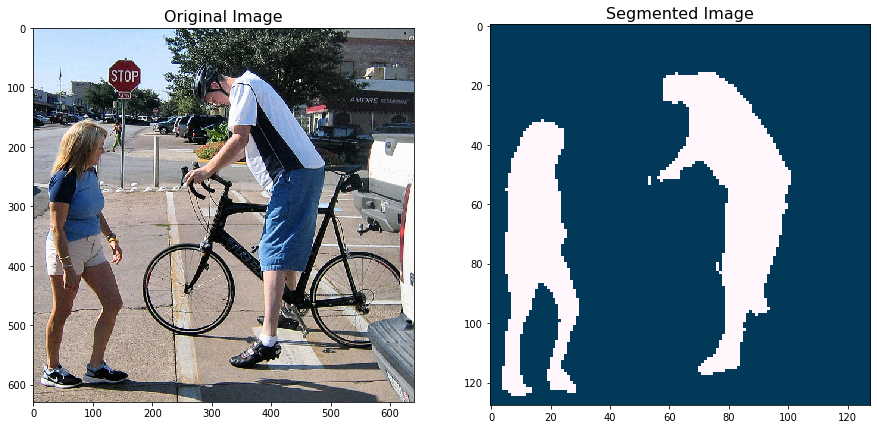

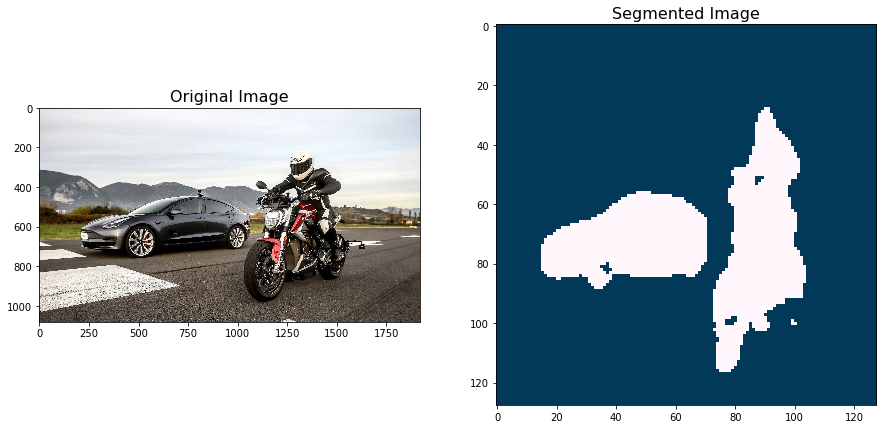

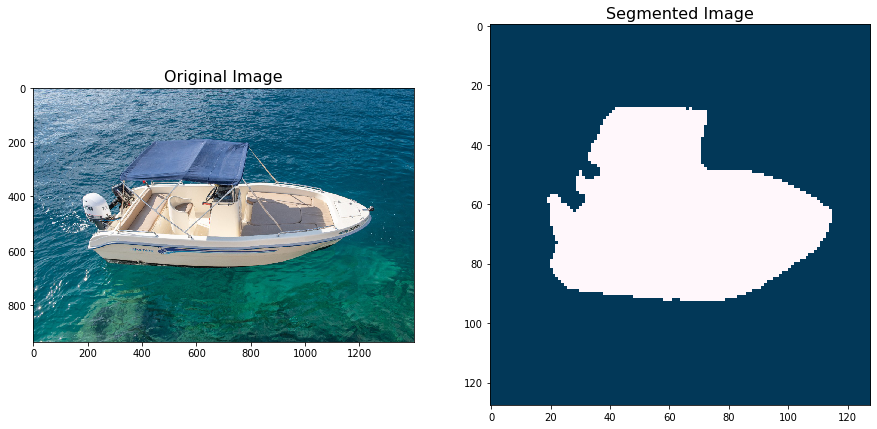

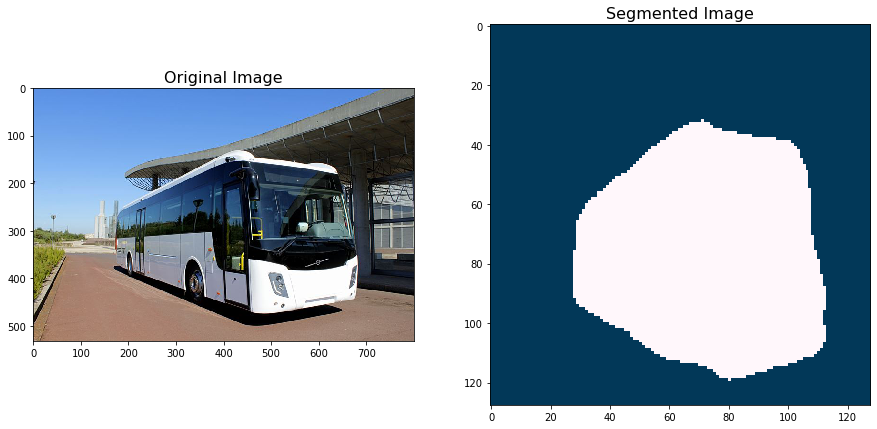

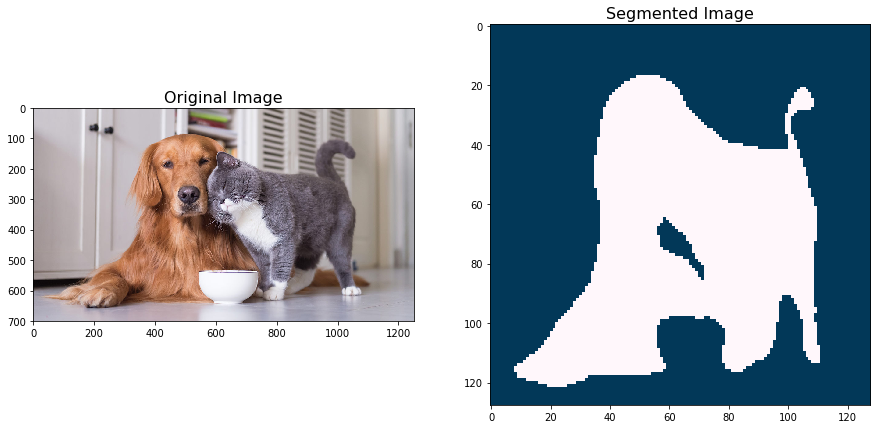

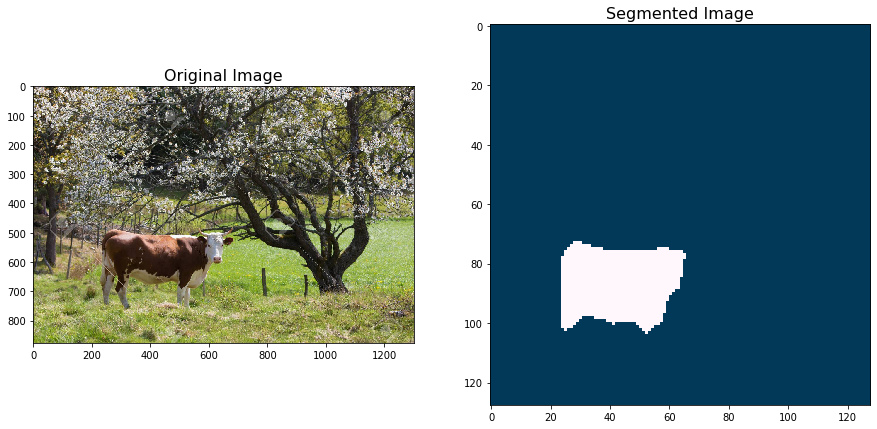

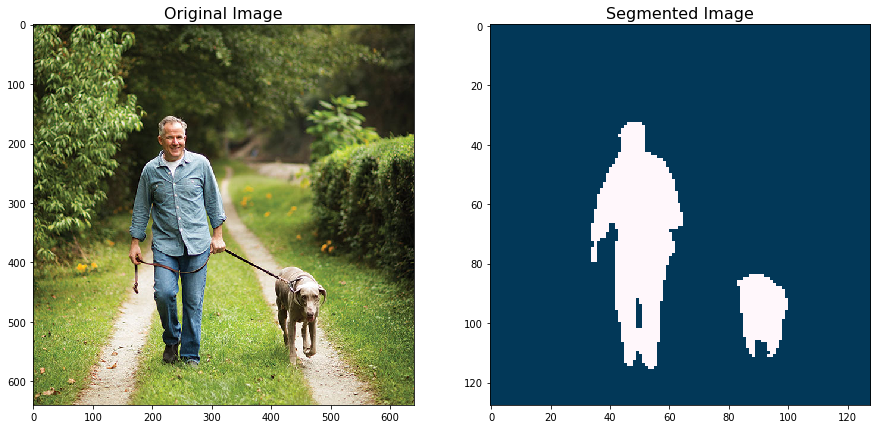

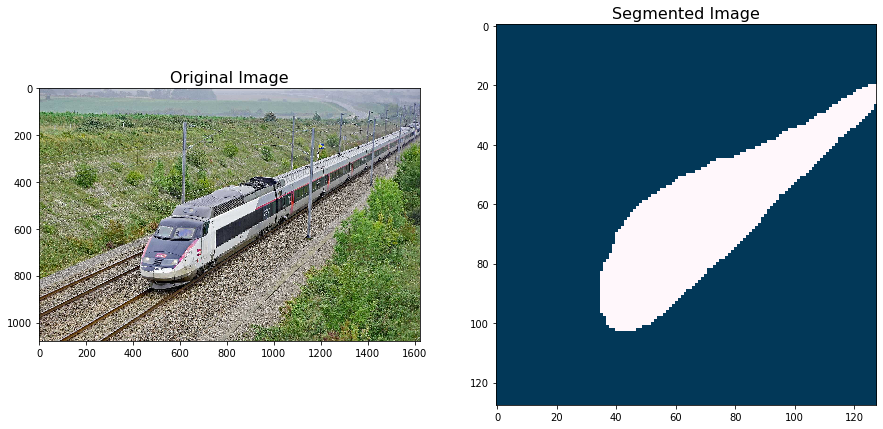

In [9]:
gmm_2 = GaussianMixture(n_components=2, covariance_type='tied')
gmm_2.fit(all_data.reshape(-1, 8))
plot_results(gmm_2)

### Do the same for a Gaussian Mixture Model with n = 4 components.

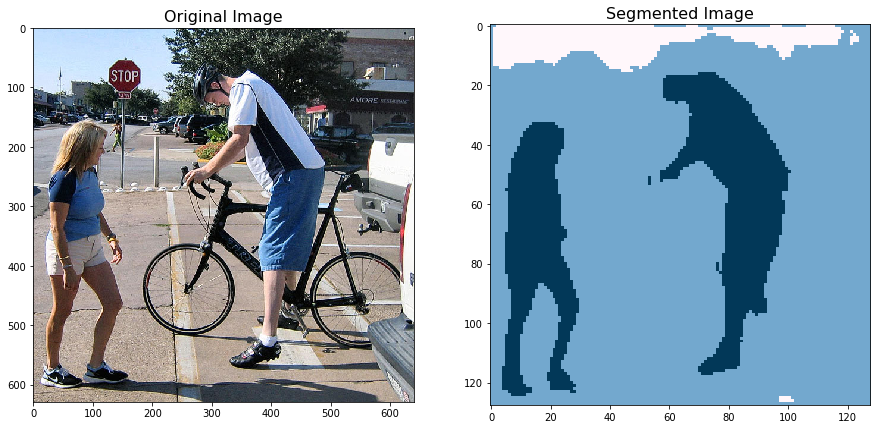

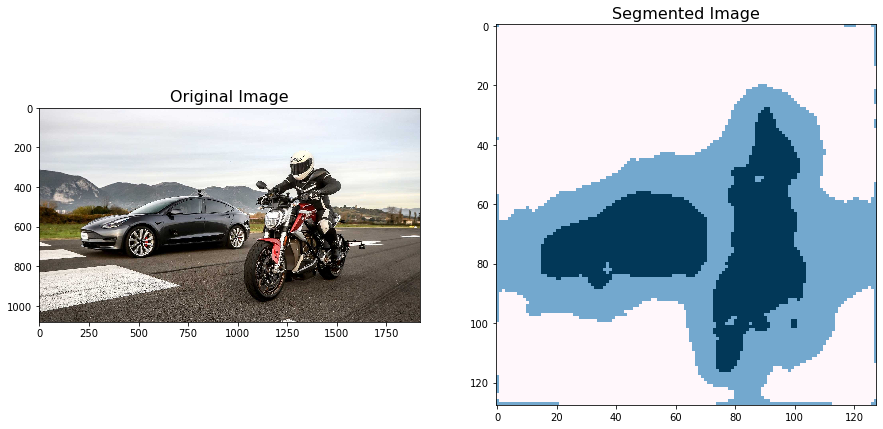

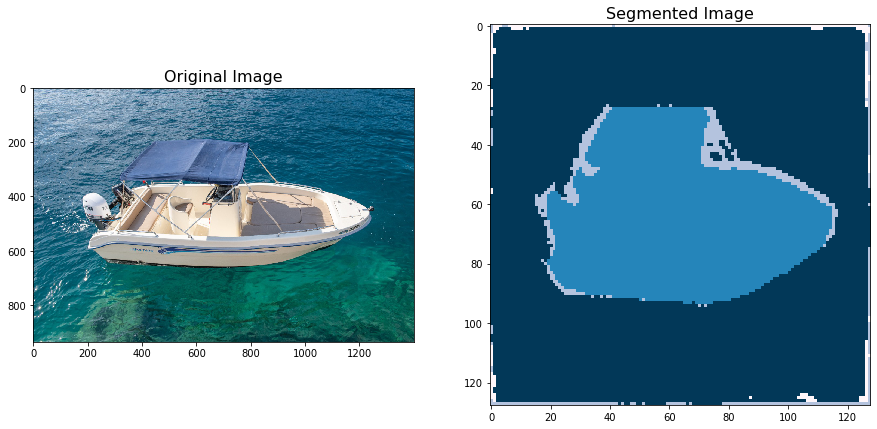

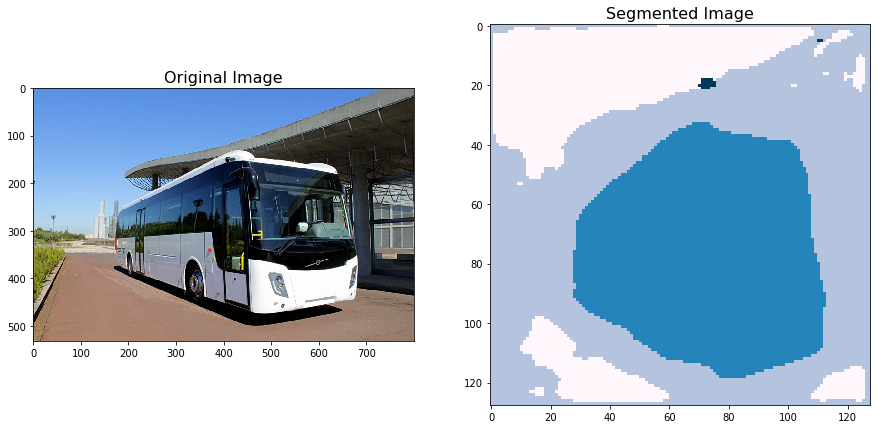

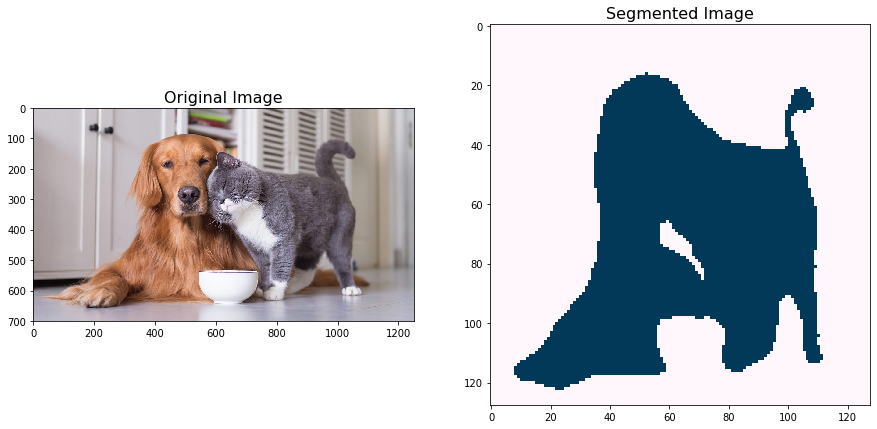

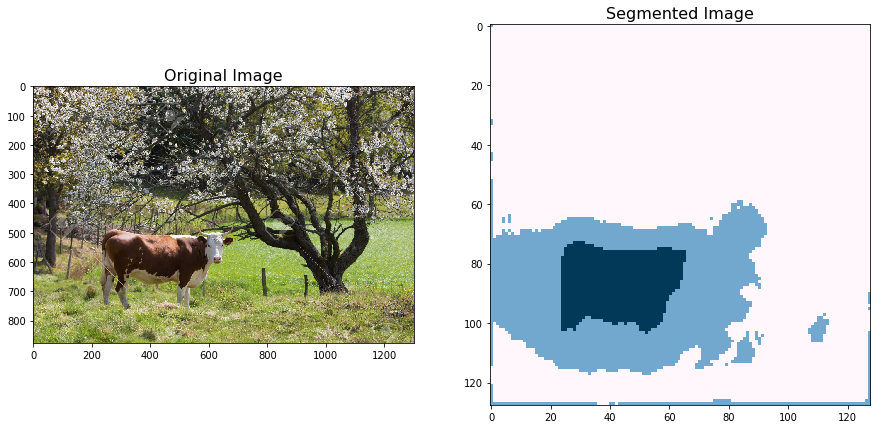

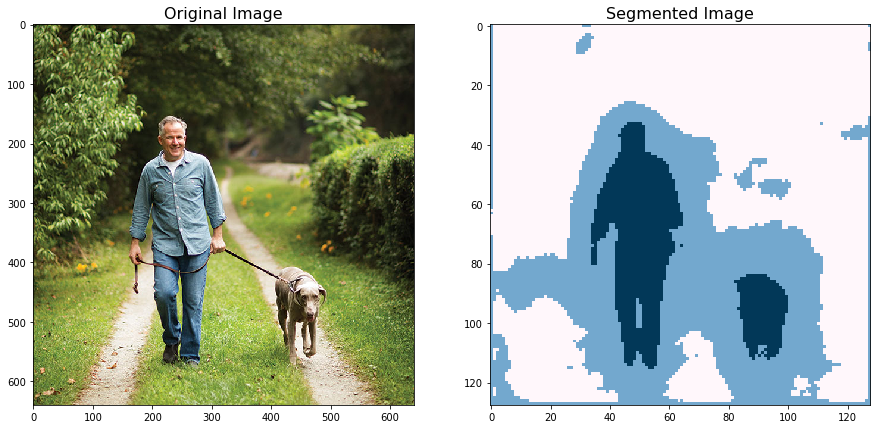

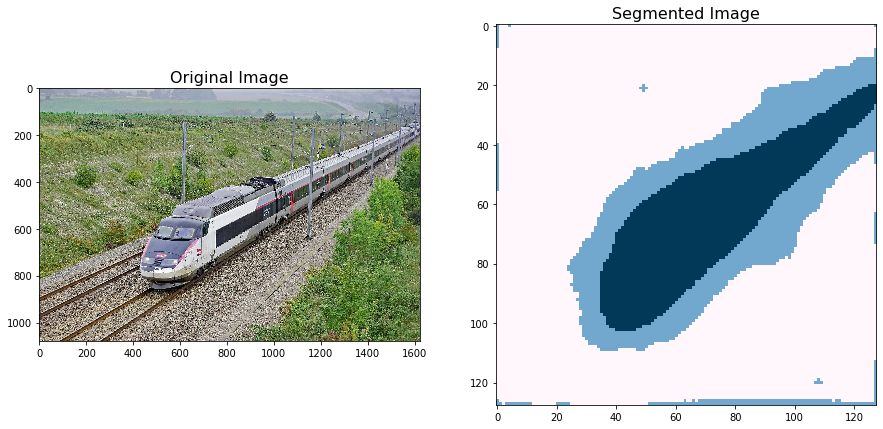

In [10]:
gmm_4= GaussianMixture(n_components=4, covariance_type='tied')
gmm_4.fit(all_data.reshape(-1, 8))
plot_results(gmm_4)

### Do the same for a Gaussian Mixture Model with n = 8 components.

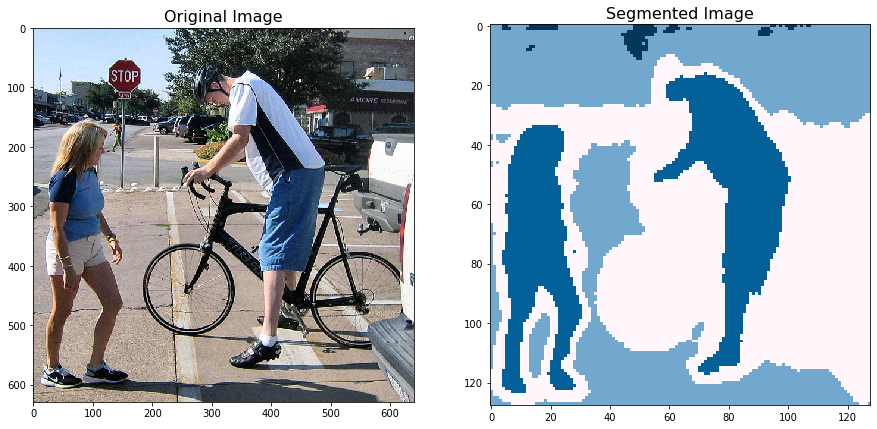

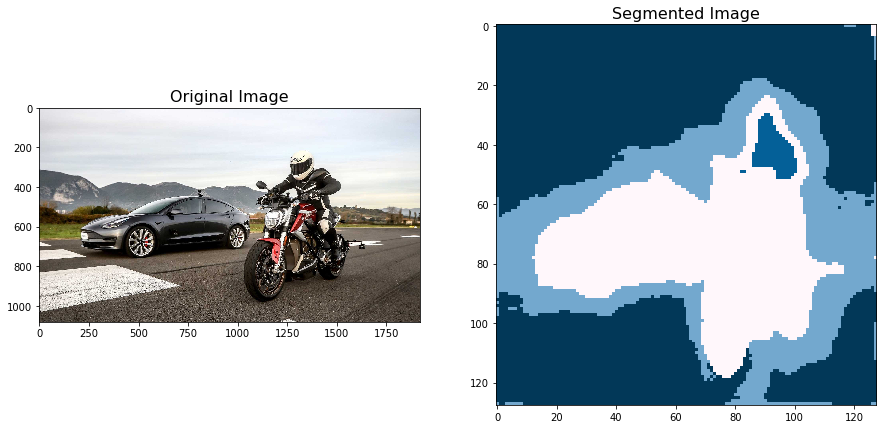

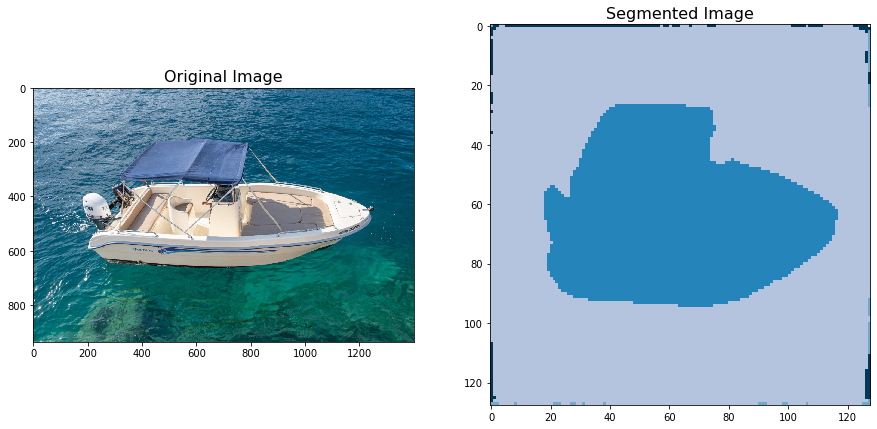

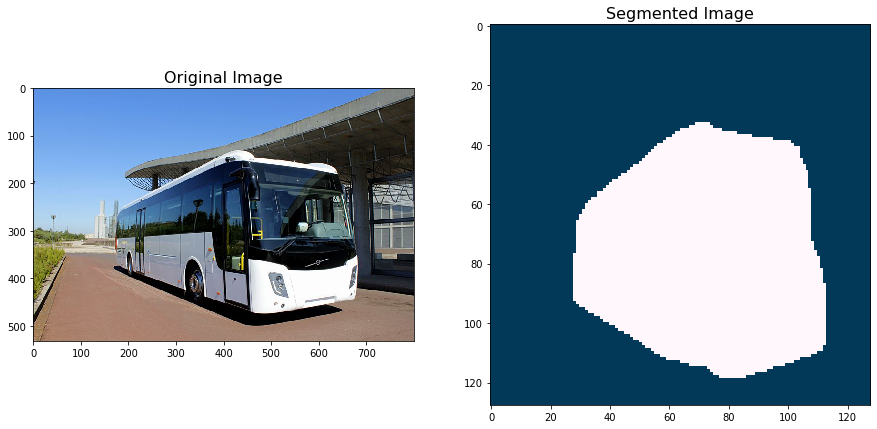

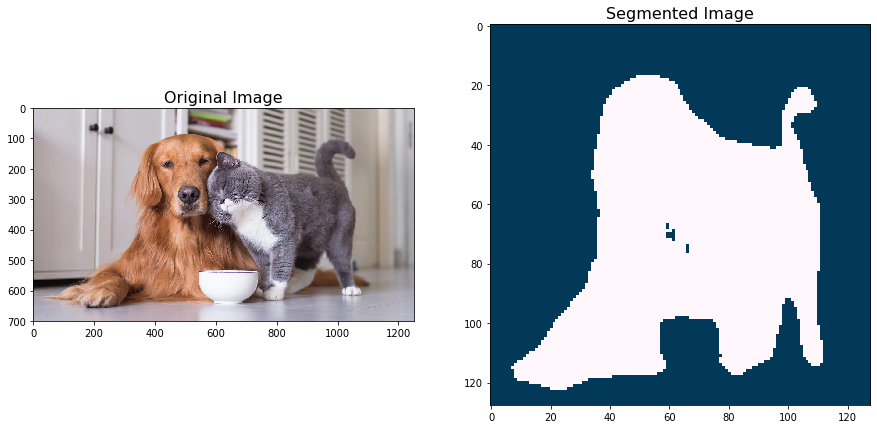

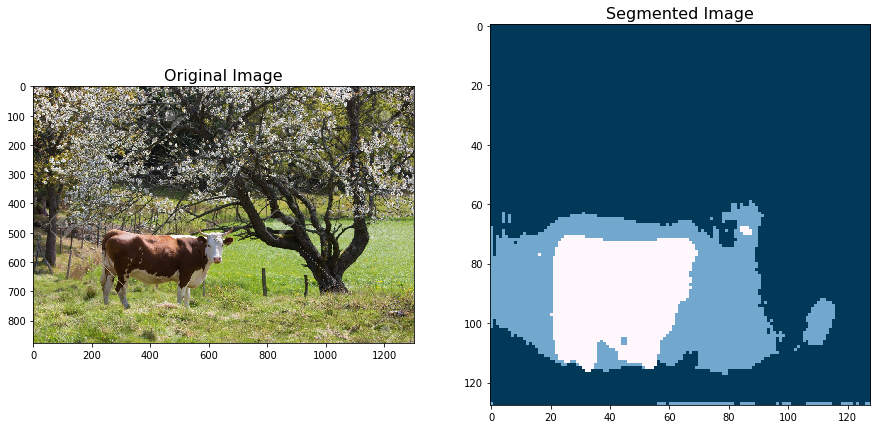

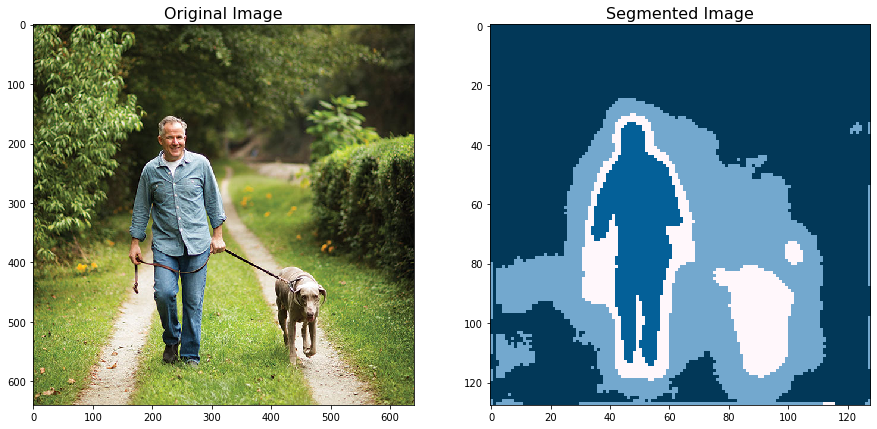

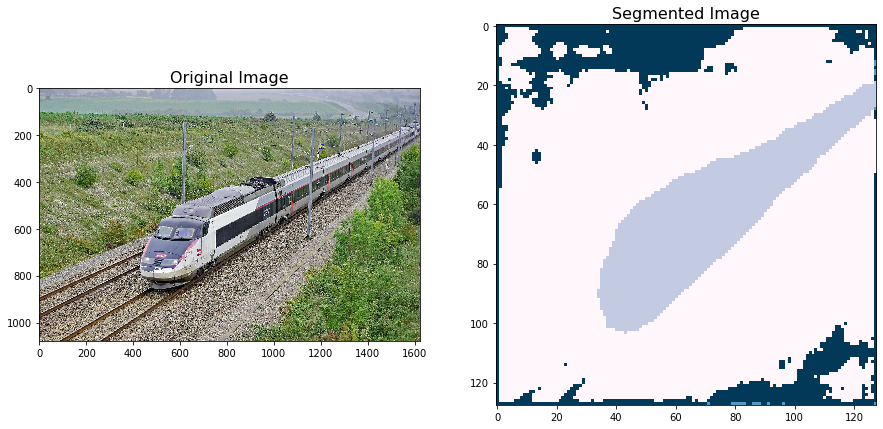

In [11]:
gmm_8 = GaussianMixture(n_components=8, covariance_type='tied')
gmm_8.fit(all_data.reshape(-1, 8))
plot_results(gmm_8)

### To test the model use a new image. Use the neural network to extract features for the new image.

In [12]:
path = 'C:\\Users\\me\\Desktop\\jeep.jpg'
new_image = plt.imread(path)
new_image_features = deeplab.predict(new_image)

### Reduce the high dimention features of the new image. Make a prediction using the Gaussian Mixture Model with n = 2 components. Finally plot the result.

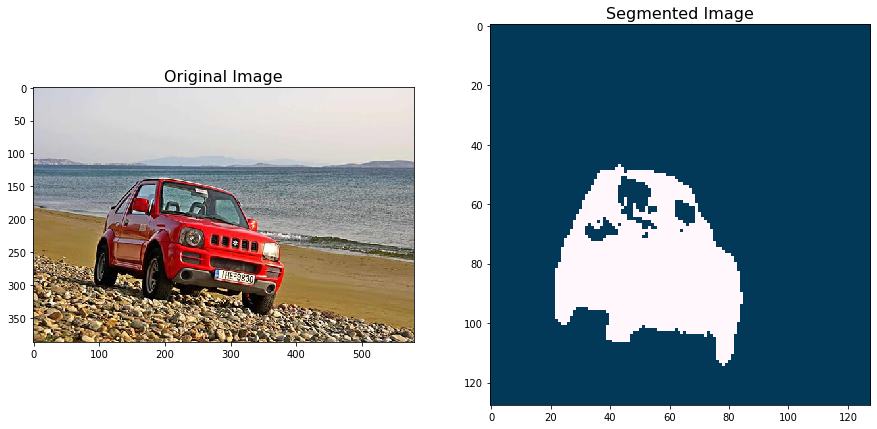

In [13]:
r = pca.transform(new_image_features.reshape(-1, d))
prediction = gmm_2.predict(r.reshape(-1, 8)).reshape(128, 128)

plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize = 16)
plt.imshow(new_image)

plt.subplot(1, 2, 2)
plt.title('Segmented Image', fontsize = 16)
plt.imshow(prediction, cmap='PuBu')
plt.show()